# Submission By Najeeb Fariduddin Saiyed
## officialnajeebsaiyed@gmail.com
### File - NTM 2
___


## Importing Libraries

In [67]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.2 MB/s eta 0:00:0000:0100:01


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Importing Our Data

In [69]:
df_train = pd.read_csv("/kaggle/input/assgt-dataset-company/DS_ML Coding Challenge Dataset (1).xlsx - Training Dataset.csv")
df_test = pd.read_csv("/kaggle/input/assgt-dataset-company/DS_ML Coding Challenge Dataset (1).xlsx - Test Dataset.csv")

---
# Lets start with NMT2

# FOR NTM2

In [84]:
# Filter the training dataset for NTM2
df_train1 = df_train[df_train['ProductType'] == 'NTM2']

# Filter the test dataset for NTM2
df_test1 = df_test[df_test['ProductType'] == 'NTM2']

In [85]:
df_train1.shape

(236726, 8)

In [86]:
df_test1.shape

(42, 8)

In [87]:
# EDA GRAPH BELOW

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


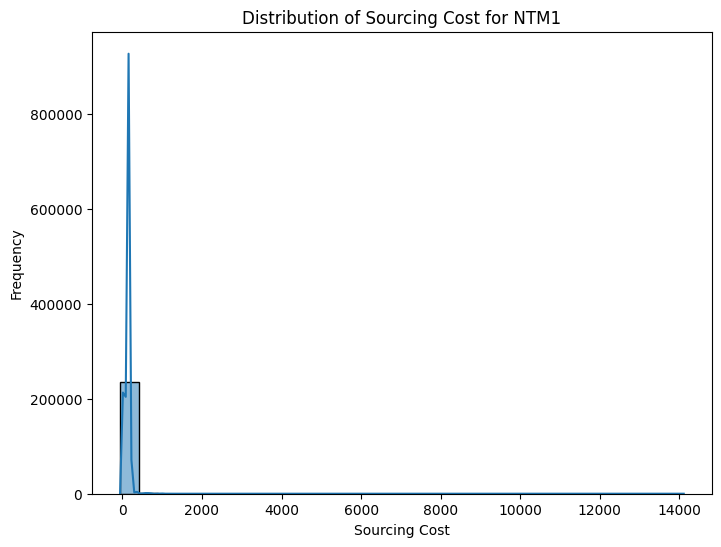

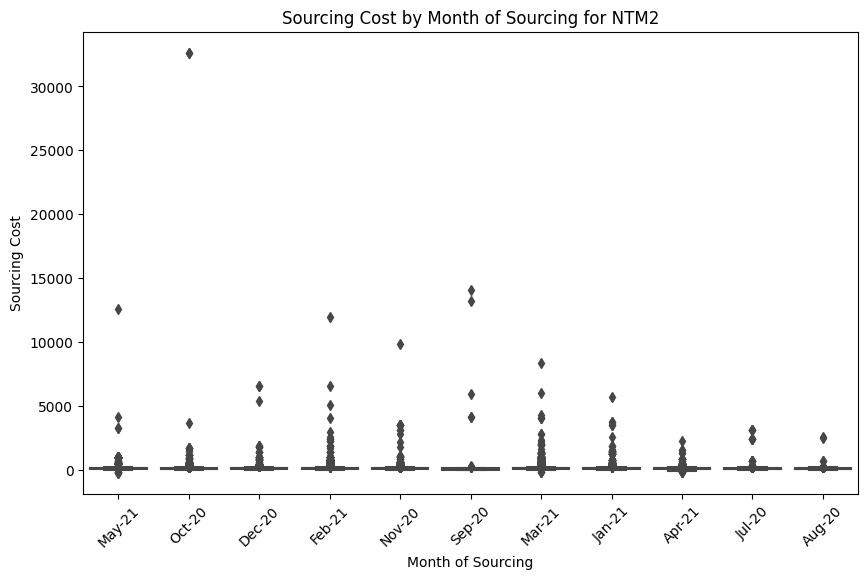

In [88]:
# Explore the distribution of the target variable (Sourcing Cost)
plt.figure(figsize=(8, 6))
sns.histplot(df_train1['Sourcing Cost'], bins=30, kde=True)
plt.title('Distribution of Sourcing Cost for NTM2')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()

# Visualize relationships between variables (e.g., Sourcing Cost vs. Month of Sourcing)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month of Sourcing', y='Sourcing Cost', data=df_train)
plt.title('Sourcing Cost by Month of Sourcing for NTM2')
plt.xlabel('Month of Sourcing')
plt.ylabel('Sourcing Cost')
plt.xticks(rotation=45)
plt.show()


---
## Removing Outliers

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


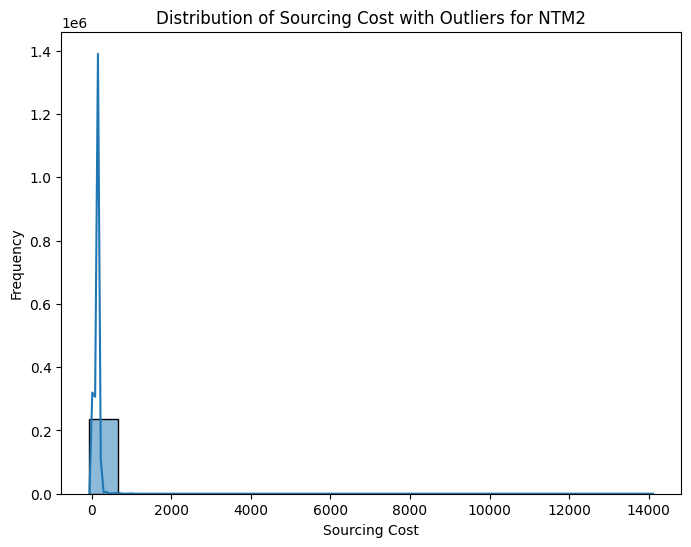

In [89]:
plt.figure(figsize=(8, 6))
sns.histplot(df_train1['Sourcing Cost'], bins=20, kde=True)
plt.title('Distribution of Sourcing Cost with Outliers for NTM2')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()


The distribution of sourcing costs is right-skewed, meaning there are more facilities with lower sourcing costs.
There are a few outliers with significantly higher sourcing costs than the rest of the facilities.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


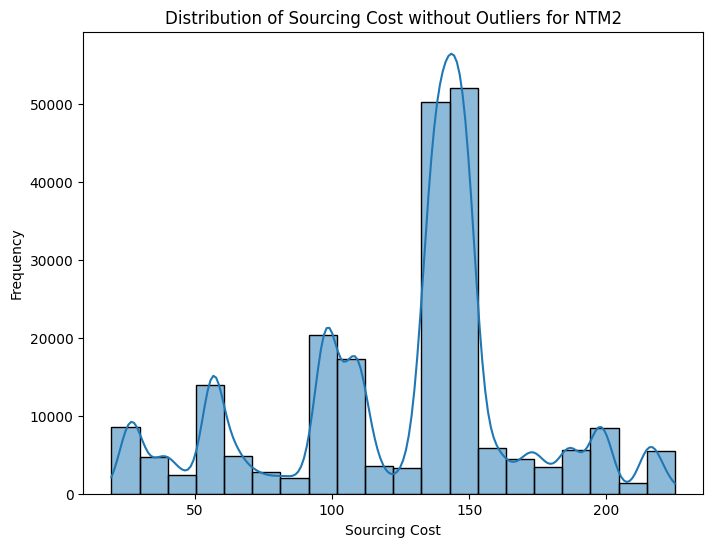

In [90]:
# Remove outliers from Sourcing Cost using IQR method
Q1 = df_train1['Sourcing Cost'].quantile(0.25)
Q3 = df_train1['Sourcing Cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_train1 = df_train1[(df_train1['Sourcing Cost'] >= lower_bound) & (df_train1['Sourcing Cost'] <= upper_bound)]

# Visualize the distribution of Sourcing Cost without outliers
plt.figure(figsize=(8, 6))
sns.histplot(df_train1['Sourcing Cost'], bins=20, kde=True)
plt.title('Distribution of Sourcing Cost without Outliers for NTM2')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()


We see from above graph the outliers have been handled pretty well and now our model is ready to be trained!

In [91]:
# Check for missing values
print("Missing Values in NTM2 Training Dataset")
print(df_train1.isnull().sum())

Missing Values in NTM2 Training Dataset
ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
dtype: int64


In [92]:
df_train = df_train1
df_train1.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76
6,NTM2,X1,A19,DIRECT,Large,Powder,Sep-20,105.59
7,NTM2,X1,A29,DIRECT,Small,Powder,Mar-21,90.78
10,NTM2,X1,A7,ECOM,Small,Powder,Mar-21,141.58


In [93]:
df_test1.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
35,NTM2,X1,A10,DIRECT,Small,Powder,Jun-21,144.89
36,NTM2,X1,A10,ECOM,Large,Powder,Jun-21,155.08
37,NTM2,X1,A11,DIRECT,Large,Liquid,Jun-21,140.03
38,NTM2,X1,A11,DIRECT,Small,Powder,Jun-21,143.08
39,NTM2,X1,A16,DIRECT,Small,Powder,Jun-21,132.60


In [94]:
df_train1.drop("ProductType", axis=1, inplace=True)
df_test1.drop("ProductType", axis=1, inplace=True)

/tmp/ipykernel_34/1069969645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1.drop("ProductType", axis=1, inplace=True)


In [95]:
df_train1.head()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
1,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
4,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76
6,X1,A19,DIRECT,Large,Powder,Sep-20,105.59
7,X1,A29,DIRECT,Small,Powder,Mar-21,90.78
10,X1,A7,ECOM,Small,Powder,Mar-21,141.58


In [96]:
df_test1.head()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
35,X1,A10,DIRECT,Small,Powder,Jun-21,144.89
36,X1,A10,ECOM,Large,Powder,Jun-21,155.08
37,X1,A11,DIRECT,Large,Liquid,Jun-21,140.03
38,X1,A11,DIRECT,Small,Powder,Jun-21,143.08
39,X1,A16,DIRECT,Small,Powder,Jun-21,132.60


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


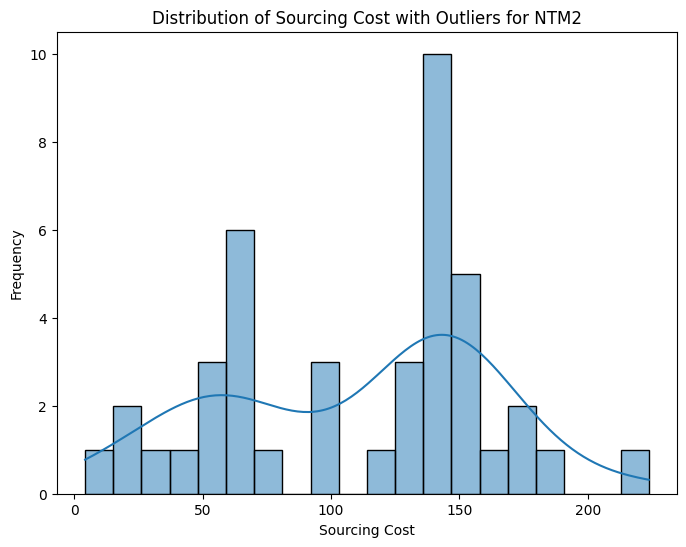

In [97]:
plt.figure(figsize=(8, 6))
sns.histplot(df_test1['Sourcing Cost'], bins=20, kde=True)
plt.title('Distribution of Sourcing Cost with Outliers for NTM2')
plt.xlabel('Sourcing Cost')
plt.ylabel('Frequency')
plt.show()


since distribution of test has no outliers our testing will be done in a more valid format and will result in better conlucsion

---
# EDA WITH PRODUCT NTM2

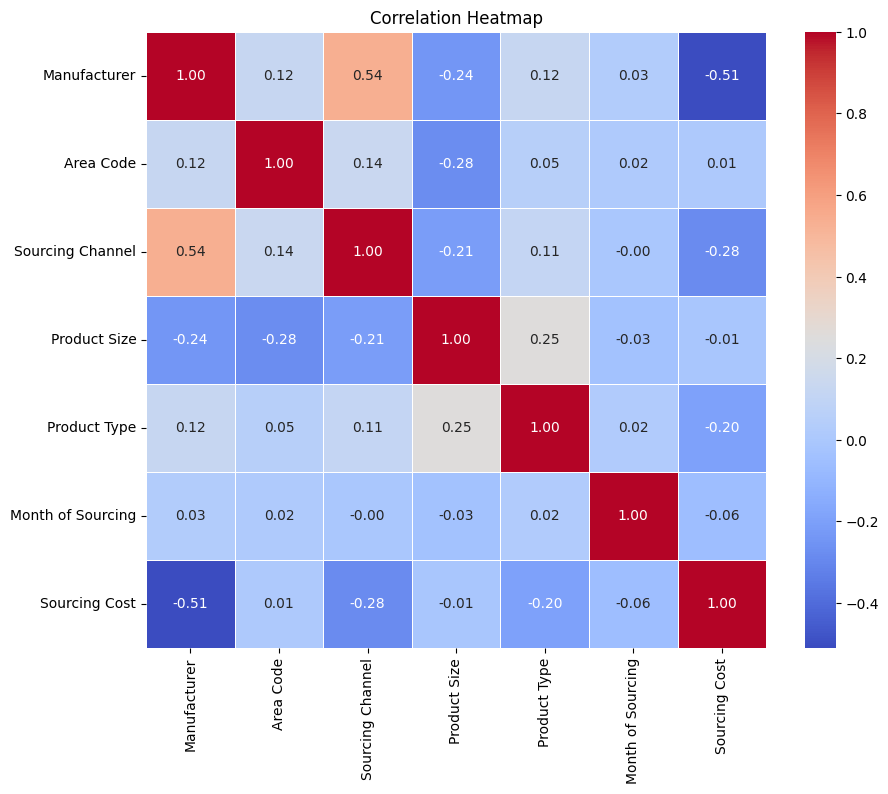

In [98]:
df_encoded = df_train1.copy()

label_encoder = LabelEncoder()

for column in df_encoded.select_dtypes(include='object').columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

plt.figure(figsize=(10, 8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [99]:
df_encoded

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
1,0,26,0,0,1,9,134.28
4,0,10,0,0,0,8,197.76
6,0,4,0,0,1,10,105.59
7,0,11,0,1,1,6,90.78
10,0,24,1,1,1,6,141.58
...,...,...,...,...,...,...,...
550169,0,10,0,0,1,3,216.34
550170,0,11,0,0,1,8,56.52
550171,0,22,0,0,1,5,136.47
550173,0,22,0,1,1,6,147.64


---
# Training Model

In [100]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

ValueError: y contains previously unseen labels: 'Jun-21'

# Expected Error Caught ✅

# As expected we got error because of Jun-21 being present in our data so lets modify our data a bit only for label encoder

In [101]:
df_train1.tail()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
550169,X1,A28,DIRECT,Large,Powder,Feb-21,216.34
550170,X1,A29,DIRECT,Large,Powder,Nov-20,56.52
550171,X1,A5,DIRECT,Large,Powder,Jul-20,136.47
550173,X1,A5,DIRECT,Small,Powder,Mar-21,147.64
550174,X1,A7,DIRECT,Small,Powder,Feb-21,150.04


In [102]:
new_row1 = {
    'Manufacturer': 'X1',
    'Area Code': 'A3',
    'Sourcing Channel': 'DIRECT',
    'Product Size': 'Small',
    'Product Type': 'Powder',
    'Month of Sourcing': 'Jun-21',
    'Sourcing Cost': 200.0
}

new_row2 = {
    'Manufacturer': 'X1',
    'Area Code': 'A3',
    'Sourcing Channel': 'DIRECT',
    'Product Size': 'Small',
    'Product Type': 'Powder',
    'Month of Sourcing': 'July-21',
    'Sourcing Cost': 200.0
}

df_new_row1 = pd.DataFrame([new_row1])
df_new_row2 = pd.DataFrame([new_row2])

df_train1 = pd.concat([df_train1, df_new_row1, df_new_row2], ignore_index=True)

df_train1.tail()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
220737,X1,A5,DIRECT,Large,Powder,Jul-20,136.47
220738,X1,A5,DIRECT,Small,Powder,Mar-21,147.64
220739,X1,A7,DIRECT,Small,Powder,Feb-21,150.04
220740,X1,A3,DIRECT,Small,Powder,Jun-21,200.00
220741,X1,A3,DIRECT,Small,Powder,July-21,200.00


In [103]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])


X_train = X_train[:-2]
y_train = y_train[:-2]

model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression task
    n_estimators=1000,             # Number of boosting rounds (trees)
    max_depth=6,                   # Maximum depth of each tree
    learning_rate=0.1,             # Learning rate (step size shrinkage)
    subsample=0.8,                 # Subsample ratio of the training instance
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    random_state=42                # Random seed for reproducibility
)

model.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Evaluate the model
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE:", test_rmse)


Test RMSE: 49.61272723566862


### Future Scope: Use grid search cv to optimise parameters

In [104]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print("\nTest RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-squared:", test_r2)


Training RMSE: 15.102367993067412
Training MAE: 6.346038619345682
Training R-squared: 0.8837935958438606

Test RMSE: 49.61272723566862
Test MAE: 28.616435988289968
Test R-squared: 0.09288678340474044


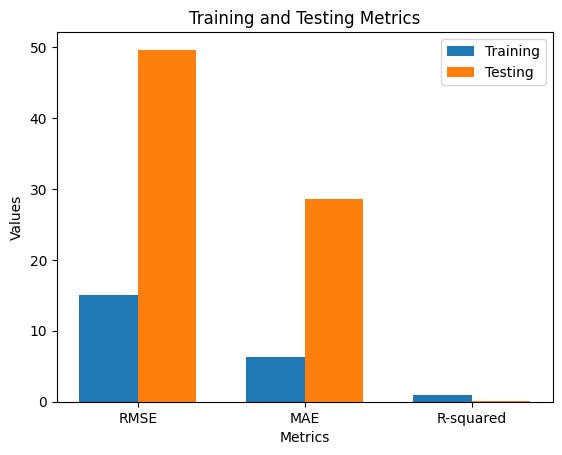

In [105]:
labels = ['RMSE', 'MAE', 'R-squared']

train_metrics = [train_rmse, train_mae, train_r2]

test_metrics = [test_rmse, test_mae, test_r2]

x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
train_rects = ax.bar(x, train_metrics, width, label='Training')
test_rects = ax.bar([i + width for i in x], test_metrics, width, label='Testing')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Training and Testing Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

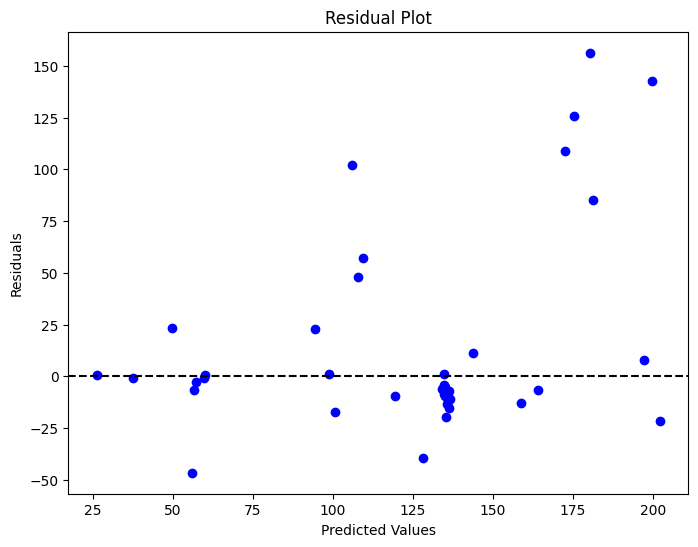

In [106]:

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, y_pred_test - y_test, color='blue')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()


The residuals appear to be scattered randomly around the zero line, indicating that the overall model fit may be reasonable.
There is a slight pattern where the residuals seem to be more negative for lower predicted values and more positive for higher predicted values. This suggests that the model may be slightly under-predicting for lower values and over-predicting for higher values.
There are a few outliers or large residuals, both positive and negative, which could be influential points or potential outliers that may need further investigation.
The spread of the residuals appears to be relatively consistent across the range of predicted values, suggesting that the assumption of constant variance (homoscedasticity) may be met.

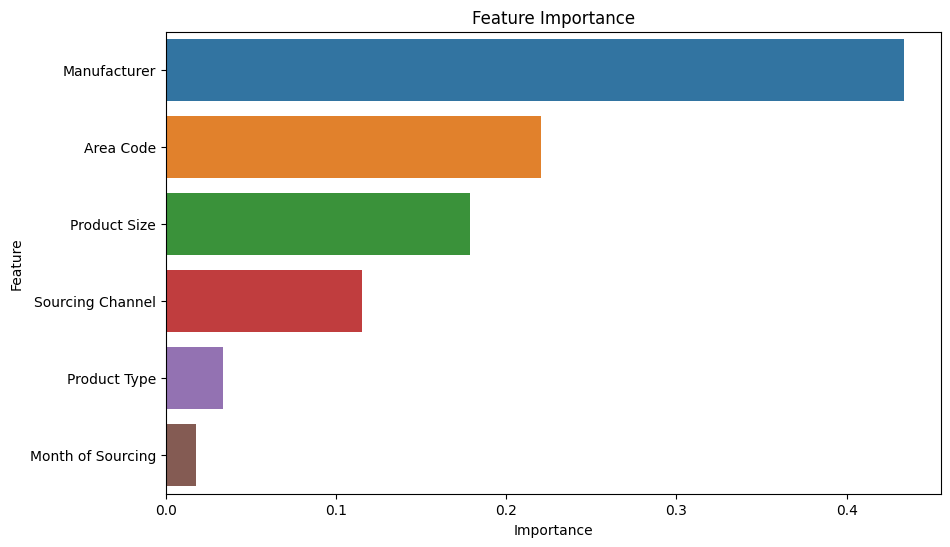

In [107]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# training neural networks

In [108]:
df_train1.tail()

,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
220737,X1,A5,DIRECT,Large,Powder,Jul-20,136.47
220738,X1,A5,DIRECT,Small,Powder,Mar-21,147.64
220739,X1,A7,DIRECT,Small,Powder,Feb-21,150.04
220740,X1,A3,DIRECT,Small,Powder,Jun-21,200.00
220741,X1,A3,DIRECT,Small,Powder,July-21,200.00


In [109]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

X_train = X_train[:-2] # removing last two rows
y_train = y_train[:-2]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
 106/5519 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 14922.7070  

I0000 00:00:1715534864.549251     153 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5519/5519 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 2909.5583 - val_loss: 1156.5934
Epoch 2/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 984.0767 - val_loss: 911.8174
Epoch 3/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 773.3831 - val_loss: 757.6136
Epoch 4/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 632.7894 - val_loss: 564.9918
Epoch 5/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 516.4838 - val_loss: 439.6158
Epoch 6/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 443.1230 - val_loss: 384.2852
Epoch 7/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 412.4986 - val_loss: 355.9041
Epoch 8/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 397.8387 - val_loss: 406.4291
Epoch 9/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 397.6846 - val_loss: 388.3490
Epoch 10/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 381.3891 - val_loss: 373.1088
Epoch 11/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 377.7906 - val_loss: 373

In [110]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print("\nTest RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-squared:", test_r2)

6899/6899 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Training RMSE: 17.087837681458616
Training MAE: 9.796643900277918
Training R-squared: 0.8512304031749287

Test RMSE: 47.94236762831419
Test MAE: 28.962013489859444
Test R-squared: 0.152939855248847


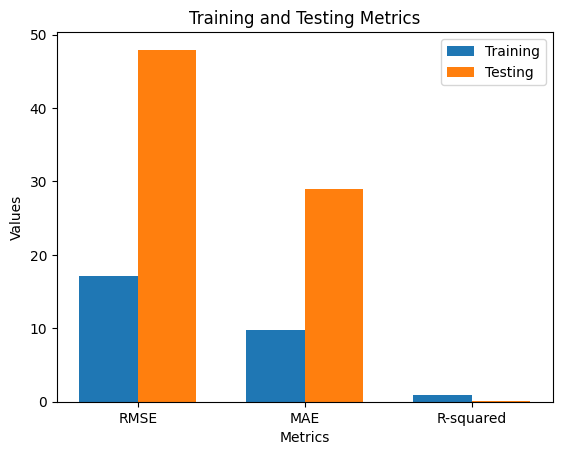

In [111]:
labels = ['RMSE', 'MAE', 'R-squared']
train_metrics = [train_rmse, train_mae, train_r2]
test_metrics = [test_rmse, test_mae, test_r2]
x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
train_rects = ax.bar(x, train_metrics, width, label='Training')
test_rects = ax.bar([i + width for i in x], test_metrics, width, label='Testing')
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Training and Testing Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
plt.show()


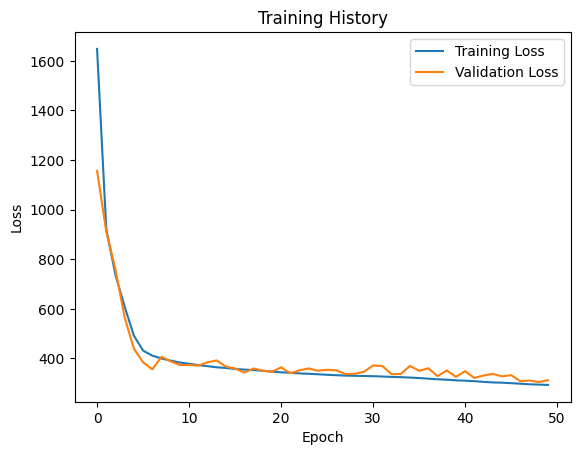

In [112]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()


# Using Complex Architecture

In [113]:
X_train = df_train1.drop(columns=['Sourcing Cost'])
y_train = df_train1['Sourcing Cost']

X_test = df_test1.drop(columns=['Sourcing Cost'])
y_test = df_test1['Sourcing Cost']

label_encoder = LabelEncoder()
categorical_cols = X_train.select_dtypes(include='object').columns

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

    
X_train = X_train[:-2]
y_train = y_train[:-2]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5519/5519 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1707.1470 - val_loss: 533.1709
Epoch 2/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 469.7451 - val_loss: 327.5335
Epoch 3/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 329.4272 - val_loss: 290.7065
Epoch 4/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 305.6664 - val_loss: 276.5797
Epoch 5/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 285.9500 - val_loss: 274.6895
Epoch 6/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 299.4838 - val_loss: 269.0580
Epoch 7/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 298.2598 - val_loss: 275.5761
Epoch 8/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 264.8100 - val_loss: 270.5863
Epoch 9/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 270.6577 - val_loss: 258.9779
Epoch 10/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 271.4673 - val_loss: 307.6786
Epoch 11/50
5519/5519 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 282.0230 - val_

In [114]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print("\nTest RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R-squared:", test_r2)

6899/6899 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Training RMSE: 15.505850786893983
Training MAE: 7.23033218145029
Training R-squared: 0.8775013882523414

Test RMSE: 49.36934933288671
Test MAE: 27.47697456359863
Test R-squared: 0.10176473959607679


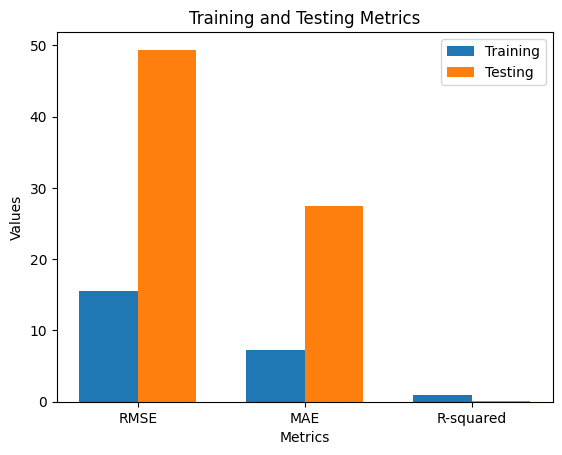

In [115]:
labels = ['RMSE', 'MAE', 'R-squared']
train_metrics = [train_rmse, train_mae, train_r2]
test_metrics = [test_rmse, test_mae, test_r2]
x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
train_rects = ax.bar(x, train_metrics, width, label='Training')
test_rects = ax.bar([i + width for i in x], test_metrics, width, label='Testing')
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Training and Testing Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
plt.show()


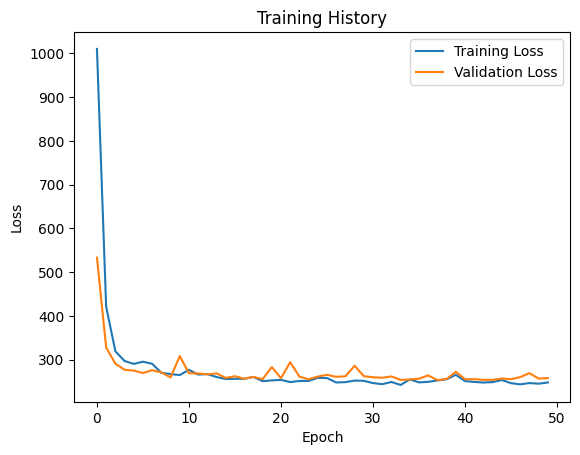

In [116]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()


### Conclusion:
Simple Architecture performs better and is approximately equivalent to that of XGBoost trained. Deeper architectures performs poor indicating understanding of data might not be as complex of a job for the neural entwork at the moment.

---
# arima 

In [122]:
auto_model = pm.auto_arima(df_train1['Sourcing Cost'], seasonal=False, trace=True)
best_params = auto_model.get_params()
print("Best Parameters:", best_params)

In [125]:
auto_model = pm.auto_arima(df_train1['Sourcing Cost'], seasonal=True, m=12, trace=True)

best_params = auto_model.get_params()
print("Best Parameters:", best_params)


### RAM insufficient error (I can go ahead and remove variables that are taking space but due to time constraint im going ahead but by using 'del' and the variable name i can free RAM and restart this cell which fits as a great alternative solution) 

*  ARIMA(1,0,0)(0,0,0)[12] intercept   As RAM keeps crashing for now we are taking this random values to see how well it model performs

In [117]:
# Fit the ARIMA model to the entire training data
order = (1, 0, 0)  # Non-seasonal parameters (p, d, q)
seasonal_order = (0, 0, 0, 12)  # Seasonal parameters (P, D, Q, S)
model = ARIMA(df_train1['Sourcing Cost'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          Sourcing Cost   No. Observations:               220742
Model:                 ARIMA(1, 0, 0)   Log Likelihood            -1150038.797
Date:                Sun, 12 May 2024   AIC                        2300083.594
Time:                        17:47:18   BIC                        2300114.508
Sample:                             0   HQIC                       2300092.654
                             - 220742                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.8346      0.101   1244.732      0.000     125.636     126.033
ar.L1          0.0151      0.002      7.145      0.000       0.011       0.019
sigma2      1962.3195      6.293    311.841      0.0

In [118]:
y_pred_train = model_fit.predict(start=df_train1.index[0], end=df_train1.index[-1])

train_rmse = np.sqrt(mean_squared_error(df_train1['Sourcing Cost'], y_pred_train))
train_mae = mean_absolute_error(df_train1['Sourcing Cost'], y_pred_train)
train_r2 = r2_score(df_train1['Sourcing Cost'], y_pred_train)

print("Training RMSE:", train_rmse)
print("Training MAE:", train_mae)
print("Training R-squared:", train_r2)
print('')

y_pred_test = model_fit.forecast(steps=len(df_test1))

# Calculate metrics for testing dataset
test_rmse = np.sqrt(mean_squared_error(df_test1['Sourcing Cost'], y_pred_test))
test_mae = mean_absolute_error(df_test1['Sourcing Cost'], y_pred_test)
test_r2 = r2_score(df_test1['Sourcing Cost'], y_pred_test)

print("Testing RMSE:", test_rmse)
print("Testing MAE:", test_mae)
print("Testing R-squared:", test_r2)


Training RMSE: 44.29797865381457
Training MAE: 35.03358143582429
Training R-squared: 0.00022863758344859875

Testing RMSE: 54.42323600778675
Testing MAE: 44.19316442208486
Testing R-squared: -0.09155095829980708


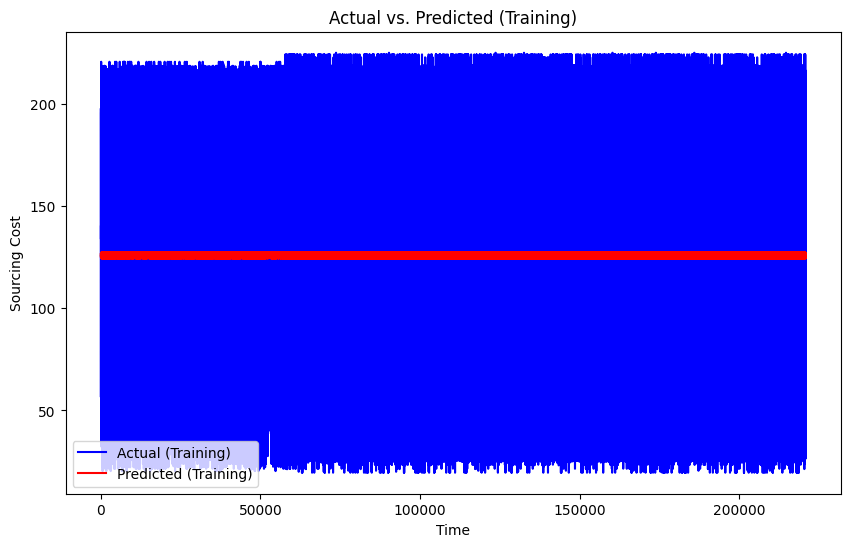

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(df_train1.index, df_train1['Sourcing Cost'], label='Actual (Training)', color='blue')
plt.plot(df_train1.index, y_pred_train, label='Predicted (Training)', color='red')
plt.xlabel('Time')
plt.ylabel('Sourcing Cost')
plt.title('Actual vs. Predicted (Training)')
plt.legend()
plt.show()


Overall we see ARIMA doesnt perform well based on RMSE , MAE AND R2 values 

In [120]:
# Define the SARIMA model parameters (p, d, q) and seasonal parameters (P, D, Q, S)
order = (1, 0, 0)  # Non-seasonal parameters (p, d, q)
seasonal_order = (0, 0, 0, 12)  # Seasonal parameters (P, D, Q, S)

model_sarima = SARIMAX(df_train1['Sourcing Cost'], order=order, seasonal_order=seasonal_order)
model_fit_sarima = model_sarima.fit()
print(model_fit_sarima.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52103D+00    |proj g|=  2.35012D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   2.350D-07   5.521D+00
  F =   5.5210317861058780     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:          Sourcing Cost   No. Observations:               220742
Model:               SARIMAX(1, 0, 0

In [121]:
y_pred_train_sarima = model_fit_sarima.predict(start=df_train1.index[0], end=df_train1.index[-1])

train_rmse_sarima = np.sqrt(mean_squared_error(df_train1['Sourcing Cost'], y_pred_train_sarima))
train_mae_sarima = mean_absolute_error(df_train1['Sourcing Cost'], y_pred_train_sarima)
train_r2_sarima = r2_score(df_train1['Sourcing Cost'], y_pred_train_sarima)

print("Training RMSE (SARIMA):", train_rmse_sarima)
print("Training MAE (SARIMA):", train_mae_sarima)
print("Training R-squared (SARIMA):", train_r2_sarima)
print('')

y_pred_test_sarima = model_fit_sarima.forecast(steps=len(df_test1))

test_rmse_sarima = np.sqrt(mean_squared_error(df_test1['Sourcing Cost'], y_pred_test_sarima))
test_mae_sarima = mean_absolute_error(df_test1['Sourcing Cost'], y_pred_test_sarima)
test_r2_sarima = r2_score(df_test1['Sourcing Cost'], y_pred_test_sarima)

print("Testing RMSE (SARIMA):", test_rmse_sarima)
print("Testing MAE (SARIMA):", test_mae_sarima)
print("Testing R-squared (SARIMA):", test_r2_sarima)


Training RMSE (SARIMA): 60.4670472946416
Training MAE (SARIMA): 47.717142434254136
Training R-squared (SARIMA): -0.8628178773001742

Testing RMSE (SARIMA): 93.29357443948595
Testing MAE (SARIMA): 77.27938037875299
Testing R-squared (SARIMA): -2.207589316515895


Again we see SARIMA Doesnt perform well

## Conclusion:
### XGBoost ≈ Neural Netowrk w/ simple architecture > Neural Netowrk w/ deeper architecture > ARIMA(Fine tuning required) > SARIMA (Fine tuning required)

---
## Future Directions and Improvements
In my analysis of time series forecasting using models like ARIMA, SARIMA, neural networks, and XGBoost, I've identified several areas for future exploration and improvement.

1. Feature Engineering:
Explore Additional Features: Investigate the incorporation of external factors such as economic indicators, weather data, or seasonal trends into the forecasting models to capture more comprehensive patterns in the data.
Transformations and Aggregations: Experiment with different transformations or aggregations of existing features to uncover more nuanced relationships and improve the predictive performance of the models.
2. Model Selection:
Advanced Models: Consider the adoption of more sophisticated time series forecasting models such as Prophet, LSTM (Long Short-Term Memory), or GRU (Gated Recurrent Unit) to better capture nonlinear relationships and long-term dependencies in the data.
Ensemble Methods: Explore ensemble techniques like stacking or blending to combine the predictions of multiple models (e.g., SARIMA, neural networks, XGBoost) and leverage their complementary strengths for improved forecasting accuracy.
3. Hyperparameter Tuning:
Thorough Parameter Search: Conduct a comprehensive hyperparameter search for each model to identify the optimal settings, including learning rate, number of layers, regularization, and other model-specific parameters.
SARIMA Parameter Exploration: Experiment with different combinations of SARIMA parameters (p, d, q) and seasonal parameters (P, D, Q, S) to identify the most effective configuration for capturing the underlying patterns in the data.
4. Model Evaluation:
Advanced Evaluation Metrics: Utilize specialized evaluation metrics tailored to time series forecasting tasks, such as Mean Absolute Scaled Error (MASE) or Symmetric Mean Absolute Percentage Error (SMAPE), to obtain more comprehensive insights into model performance.
Cross-Validation: Implement cross-validation techniques to assess the generalization ability of the models across different time periods and ensure robust performance estimates.
5. Data Preprocessing:
Robust Data Preprocessing: Apply robust preprocessing techniques such as outlier detection, missing value imputation, and normalization or standardization to enhance the quality and consistency of the input data.
6. Ensemble Learning:
Model Combination: Explore ensemble learning approaches to combine the predictions of multiple models, mitigating individual weaknesses and producing more reliable forecasts.
Why ARIMA and SARIMA Performed Less Effectively:
Linear Assumptions: ARIMA and SARIMA models assume linear relationships between input and output variables, which may limit their ability to capture complex nonlinear patterns in the data.
Stationarity Assumption: These models require stationarity in the data, which may not always hold true in real-world datasets with trends, seasonality, or other nonlinear patterns.
Flexibility of Neural Networks and XGBoost: Neural networks and XGBoost are more flexible and adept at learning complex nonlinear relationships and patterns from data. They can automatically extract features and dependencies, making them better suited for tasks where underlying relationships are nonlinear or not well understood.
By exploring these future avenues and improvements, we can potentially enhance the predictive performance of our time series forecasting models and obtain more accurate and reliable forecasts.

---
By Najeeb Fairuddin Saiyed

najeeb.saiyed.btech2021@sitpune.edu.in

+91 8128026682